# Data Exploration and Preprocessing and EDA

## Import necessary libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix
warnings.filterwarnings('ignore')
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.text import FreqDistVisualizer

## Read data into pandas

In [2]:
wiki= pd.read_csv('./data/wiki_movie_plots_deduped.csv')

wiki.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Descriptive Statistics

The release years range from 1901 to 2017 in the dataset

In [3]:
wiki.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


There are 34886 rows and 8 columns 

In [4]:
wiki.shape

(34886, 8)

In [5]:
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


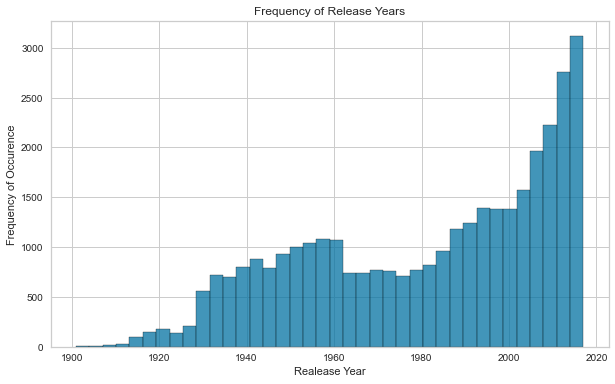

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x = wiki['Release Year'])
plt.title('Frequency of Release Years')
plt.xlabel('Realease Year')
plt.ylabel('Frequency of Occurence')
fig.savefig('./images/freqofreleaseyear.png');

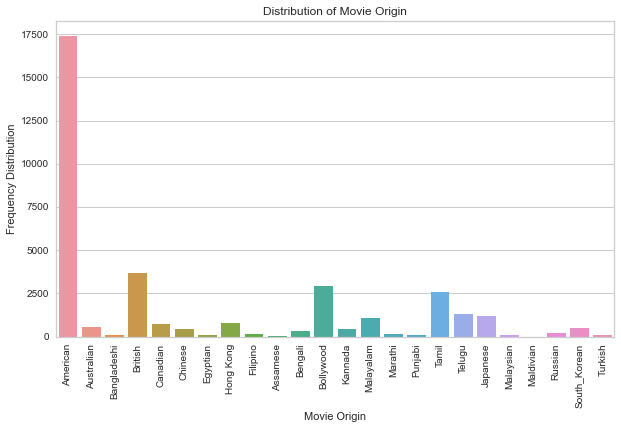

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

sns.countplot(x = wiki['Origin/Ethnicity'])
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('Distribution of Movie Origin')
plt.xlabel('Movie Origin')
plt.ylabel('Frequency Distribution')
fig.savefig('./images/FreqDistOrigin.png');

## Subsetting the dataset to include only the entries with a known genre and resetting the index

In [8]:
wiki_df = wiki.loc[wiki['Genre']!='unknown']
wiki_df.reset_index(drop = True, inplace = True)

Checking the number of unique values we have in the genres column

In [9]:
genres=pd.value_counts(wiki_df.Genre)

print('There are ',len(genres), 'different Genres in the dataset:')
print('-'*50)
print(genres)

There are  2264 different Genres in the dataset:
--------------------------------------------------
drama                                5964
comedy                               4379
horror                               1167
action                               1098
thriller                              966
                                     ... 
animation musical                       1
drama, erotic                           1
tapas paul, debashree roy               1
musical / fantasy / comedy              1
prabhas, trisha krishnan, charmme       1
Name: Genre, Length: 2264, dtype: int64


## Getting the top 6 most commonly occuring genres in the dataset

In [10]:
top_genres = pd.DataFrame(genres[:6]).reset_index()
top_genres.columns = ['genres', 'number_of_movies']
top_genres

,genres,number_of_movies
0,drama,5964
1,comedy,4379
2,horror,1167
3,action,1098
4,thriller,966
5,romance,923


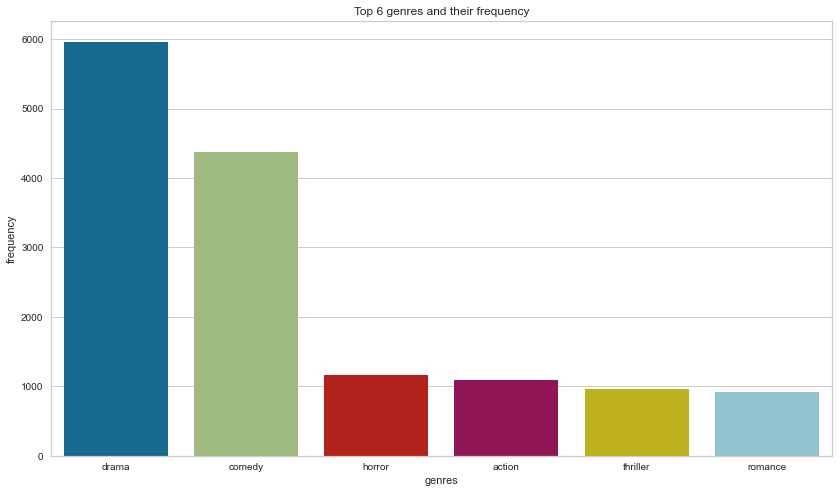

In [11]:
fig, ax = plt.subplots(figsize=(14,8))

sns.barplot(top_genres['genres'], top_genres['number_of_movies'])
plt.title('Top 6 genres and their frequency')
plt.xlabel('genres')
plt.ylabel('frequency')
fig.savefig('./images/freqoftopgenres.png')

## Creating separate labels column for the top 6 genres only and assigning the values between 1-6 for drama, comedy,horror, action, thriller and romance, respectively if present in the genre column of the movie (for entries that have only one genre)

In [12]:
conditions = [wiki_df['Genre']=='drama', wiki_df['Genre']=='comedy', wiki_df['Genre']=='horror', wiki_df['Genre']=='action', wiki_df['Genre']=='thriller',
             wiki_df['Genre']=='romance']
choices = [1,2,3,4,5,6]
wiki_df['labels'] = np.select(conditions, choices, 0)

In [13]:
wiki_df.sample(6)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
5914,1953,Serpent of the Nile,American,William Castle,"Rhonda Fleming, Raymond Burr, William Lundigan",adventure,https://en.wikipedia.org/wiki/Serpent_of_the_N...,"The film opens in 44 BC, just after the assass...",0
21213,2015,Born to Be Blue,Canadian,Robert Budreau,Ethan Hawke Carmen Ejogo,biographical drama,https://en.wikipedia.org/wiki/Born_to_Be_Blue_...,"The film is described as ""semi-factual, semi-f...",0
3375,1942,Sundown Jim,American,James Tinling,"John Kimbrough, Arleen Whelan, Virginia Gilmore",western,https://en.wikipedia.org/wiki/Sundown_Jim,"Into the town of Resurrection rides a lawman, ...",0
4809,1949,Dancing in the Dark,American,Irving Reis,"William Powell, Betsy Drake",musical,https://en.wikipedia.org/wiki/Dancing_in_the_D...,This musical comedy stars William Powell as Em...,0
26889,1963,Irugu Porugu,Telugu,I. N. Murthy,"N. T. Rama Rao, Krishna Kumari, Sobhan Babu",drama,https://en.wikipedia.org/wiki/Irugu_Porugu,Vishwanatham (Gummadi) is a poor writer and dr...,1
617,1928,Beware of Bachelors,American,Roy Del Ruth,"Audrey Ferris, William Collier Jr.",comedy,https://en.wikipedia.org/wiki/Beware_of_Bachelors,A young doctor (William Collier Jr) is accused...,2


In [14]:
wiki_df['labels'].value_counts()

0    14306
1     5964
2     4379
3     1167
4     1098
5      966
6      923
Name: labels, dtype: int64

## Subsetting the wiki_df dataframe to only include the rows that have entries (1-6) in the newly created labels columns (the ones that have only a single genre entry)

In [15]:
 df_to_use = (wiki_df.loc[wiki_df['labels']!=0]).reset_index(drop = True)

In [16]:
# We are now left with about 14 thousand rows of data
df_to_use.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,2
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,2
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,2
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,1
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,1


Dropping unnecessary columns

In [17]:
df_to_use.drop(columns = ['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'], axis = 1, inplace = True)

In [18]:
df_to_use.head(2)

,Title,Genre,Plot,labels
0,The Suburbanite,comedy,The film is about a family who move to the sub...,2
1,How Brown Saw the Baseball Game,comedy,Before heading out to a baseball game at a nea...,2


In [19]:
df_to_use.describe()

,labels
count,14497.000000
mean,2.275160
std,1.528956
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


In [20]:
import random
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

## Cleaning up the 'Plot' column

Below we are just looking at a sample of the plot summary

In [31]:
df_to_use['Plot'][5]

"A young couple decides to elope after being caught in the midst of a romantic moment by the woman's angry father. They make plans to leave, but a thief discovers their plans and hides in their trunk and waits for the right moment to steal their belongings."

Creating our stopwords list and adding some cmore words that are very common in the summaries. (I ran the freqdist after this and noticed that some of these words were very common but didn't lend us too much meaning so I came back here to add them to the stopwords list). Changing the text to lower case, removing all the stopwords in our list, stripping unnecessary space and replacing some patterns in our text

In [32]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells'] 

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

Rechecking the summary we looked at above to see if our function worked

In [33]:
df_to_use['Plot'] = df_to_use['Plot'].map(lambda x : clean_text(x))
df_to_use['Plot'][5]

'young couple decides elope caught midst romantic moment woman angry father make plans leave thief discovers plans hides trunk waits right moment steal belongings'

In [43]:
y = df_to_use['Genre']
X = df_to_use['Plot']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1500, random_state = 42)

In [45]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=1000, random_state=42)

In [46]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final)



X_train_tokens = tokenizer.texts_to_matrix(X_train_final, mode='binary')
X_val_tokens = tokenizer.texts_to_matrix(X_val, mode = 'binary')
X_test_tokens = tokenizer.texts_to_matrix(X_test, mode='binary')

In [48]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train_final)

y_train_lb = to_categorical(lb.transform(y_train_final))[:, :, 1]
y_val_lb = to_categorical(lb.transform(y_val))[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]

In [50]:
random.seed(42)
from keras import models
from keras import layers
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(50, activation = 'relu', input_shape = (2000,)))
baseline_model.add(layers.Dense(25, activation = 'relu'))
baseline_model.add(layers.Dense(6, activation = 'softmax'))

In [51]:
baseline_model.compile(optimizer='SGD',
                      loss = 'categorical_crossentropy',
                      metrics = 'accuracy')

In [52]:
baseline_model_val = baseline_model.fit(X_train_tokens, y_train_lb,
                                       epochs = 150,
                                       batch_size = 256,
                                       validation_data = (X_val_tokens, y_val_lb))

Epoch 1/150
47/47 [==============================] - 0s 7ms/step - loss: 1.7376 - accuracy: 0.3092 - val_loss: 1.6723 - val_accuracy: 0.4250
Epoch 2/150
47/47 [==============================] - 0s 4ms/step - loss: 1.6377 - accuracy: 0.4067 - val_loss: 1.5824 - val_accuracy: 0.4400
Epoch 3/150
47/47 [==============================] - 0s 4ms/step - loss: 1.5663 - accuracy: 0.4117 - val_loss: 1.5201 - val_accuracy: 0.4410
Epoch 4/150
47/47 [==============================] - 0s 5ms/step - loss: 1.5186 - accuracy: 0.4136 - val_loss: 1.4790 - val_accuracy: 0.4450
Epoch 5/150
47/47 [==============================] - 0s 5ms/step - loss: 1.4855 - accuracy: 0.4166 - val_loss: 1.4491 - val_accuracy: 0.4460
Epoch 6/150
47/47 [==============================] - 0s 6ms/step - loss: 1.4604 - accuracy: 0.4220 - val_loss: 1.4258 - val_accuracy: 0.4500
Epoch 7/150
47/47 [==============================] - 0s 5ms/step - loss: 1.4388 - accuracy: 0.4275 - val_loss: 1.4058 - val_accuracy: 0.4510
Epoch 8/150
4

Epoch 59/150
47/47 [==============================] - 0s 5ms/step - loss: 0.8265 - accuracy: 0.6916 - val_loss: 1.0284 - val_accuracy: 0.6240
Epoch 60/150
47/47 [==============================] - 0s 4ms/step - loss: 0.8211 - accuracy: 0.6938 - val_loss: 1.0280 - val_accuracy: 0.6250
Epoch 61/150
47/47 [==============================] - 0s 5ms/step - loss: 0.8157 - accuracy: 0.6949 - val_loss: 1.0275 - val_accuracy: 0.6240
Epoch 62/150
47/47 [==============================] - 0s 4ms/step - loss: 0.8103 - accuracy: 0.6971 - val_loss: 1.0266 - val_accuracy: 0.6250
Epoch 63/150
47/47 [==============================] - 0s 4ms/step - loss: 0.8048 - accuracy: 0.6996 - val_loss: 1.0257 - val_accuracy: 0.6300
Epoch 64/150
47/47 [==============================] - 0s 4ms/step - loss: 0.7998 - accuracy: 0.7023 - val_loss: 1.0255 - val_accuracy: 0.6310
Epoch 65/150
47/47 [==============================] - 0s 4ms/step - loss: 0.7944 - accuracy: 0.7031 - val_loss: 1.0252 - val_accuracy: 0.6350
Epoch 

In [53]:
baseline_model_val_dict = baseline_model_val.history

# Print the keys
baseline_model_val_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
results_train = baseline_model.evaluate(X_train_tokens, y_train_lb)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

375/375 [==============================] - 0s 551us/step - loss: 0.4604 - accuracy: 0.8514
----------
Training Loss: 0.46 
Training Accuracy: 0.851


In [58]:
results_val = baseline_model.evaluate(X_val_tokens, y_val_lb)
print('----------')
print(f'Training Loss: {results_val[0]:.3} \nTraining Accuracy: {results_val[1]:.3}')

32/32 [==============================] - 0s 724us/step - loss: 1.1559 - accuracy: 0.6140
----------
Training Loss: 1.16 
Training Accuracy: 0.614


In [59]:
results_test = baseline_model.evaluate(X_test_tokens, y_test_lb)
print('----------')
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

47/47 [==============================] - 0s 672us/step - loss: 1.2466 - accuracy: 0.5900
----------
Test Loss: 1.25 
Test Accuracy: 0.59
